In [85]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import scienceplots

from nanonets.utils import logic_gate_sample, fitness, load_boolean_results, return_ndr, return_nls, nonlinear_parameter
from nanonets import Simulation

plt.style.use(["science","bright","grid"])
folder_wo_scale = "/home/j/j_mens07/phd/data/1_funding_period/system_size/wo_scale/"
folder_scale    = "/home/j/j_mens07/phd/data/1_funding_period/system_size/scale/"

### Surrogate Model Data

In [86]:
# Load artifacts
model = tf.keras.models.load_model('../trained_model.keras')
with open('../scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)
    x_scaler = scalers['x_scaler']
    y_scaler = scalers['y_scaler']

with open('../history.pkl', 'rb') as f:
    history = pickle.load(f)

data = np.load('../test_data.npz')
X_test_scaled = data['X_test_scaled']
y_test = data['y_test']

# Predict
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


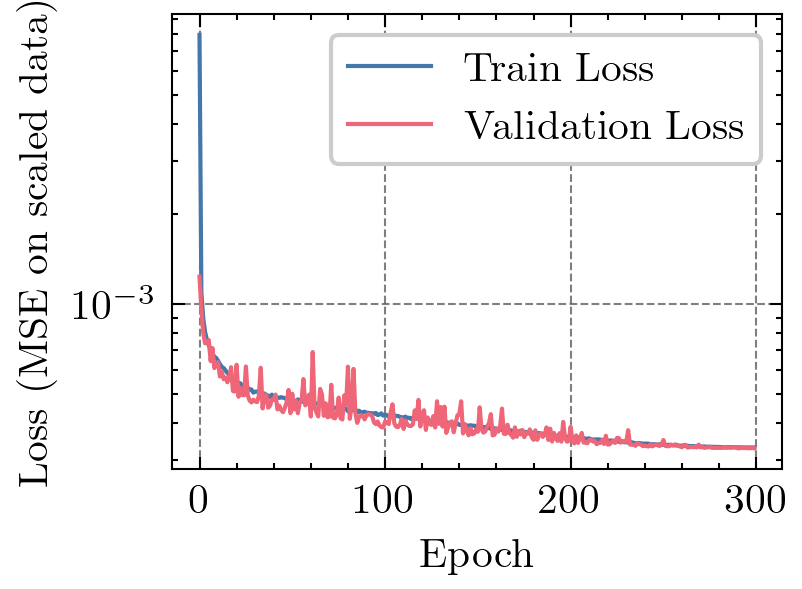

In [87]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
ax.plot(history['loss'], label='Train Loss')
ax.plot(history['val_loss'], label='Validation Loss')
ax.set_ylabel('Loss (MSE on scaled data)')
ax.set_xlabel('Epoch')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()

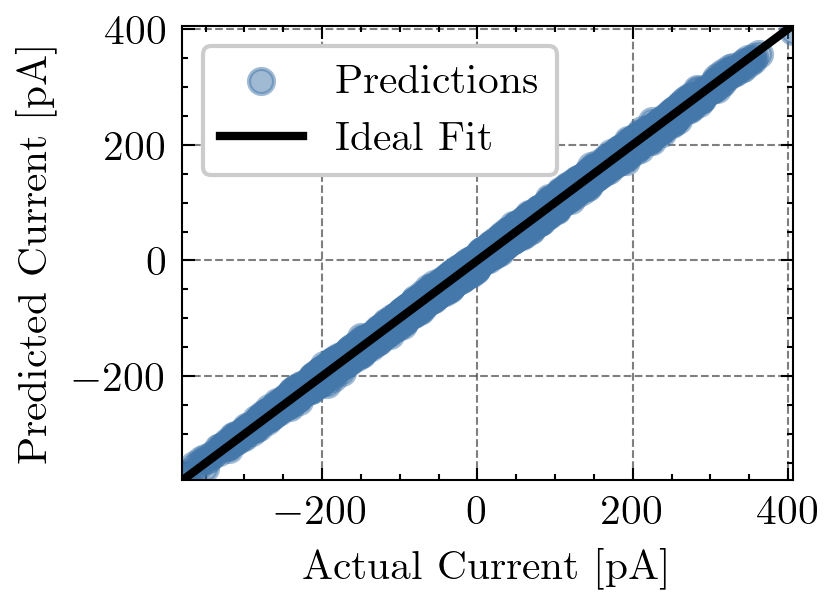

In [88]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
ax.scatter(y_test*1e-6, y_pred*1e-6, alpha=0.5, label='Predictions')
ax.plot(np.array([y_test.min(), y_test.max()])*1e-6, np.array([y_test.min(), y_test.max()])*1e-6, 'black', linewidth=2, label='Ideal Fit')
ax.set_xlim(np.array([y_test.min(), y_test.max()])*1e-6)
ax.set_ylim(np.array([y_test.min(), y_test.max()])*1e-6)
ax.set_xlabel("Actual Current~[pA]")
ax.set_ylabel("Predicted Current~[pA]")
ax.legend()

# Surrogate Model vs Sample

In [102]:
ele             = 0.160217662
M_resamples     = 0
AC_TIME         = 40e-9
BATCH_TIME      = 20*AC_TIME
I_MIN           = ele / (20*BATCH_TIME)
df_wo_scale     = load_boolean_results(folder=f"{folder_wo_scale}", N=9, N_e=8, input_cols=['E1','E3'],
                                    off_state=0.0, on_state=0.01, drop_zero=False, max_error=np.inf)
y_tmp           = df_wo_scale['Observable'].values
y_tmp_e         = df_wo_scale['Error'].values
l_t             = np.abs(y_tmp) < I_MIN
y_tmp[l_t]      = 0.0
y_tmp_e[l_t]    = 0.0

df_wo_scale['Observable']   = y_tmp
df_wo_scale['Error']        = y_tmp_e

fitness_wo_scale = fitness(df_wo_scale, input_cols=['E1','E3'], M=M_resamples, delta=0.0)

In [103]:
N_PARTICLES = 9
N_E         = 8
V_ON        = 0.01
V_OFF       = 0.0
V_RANGE     = 0.05
INPUT_POS   = [1,3]
SCALE       = True
INPUT_COL   = [f"E{INPUT_POS[0]}",f"E{INPUT_POS[1]}"]
N_SAMPLES   = 10000
TOPO        = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
                "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                [N_PARTICLES-1,int((N_PARTICLES)/2)],
                [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
                "electrode_type" : ['constant']*N_E}

In [104]:
voltages        = df_wo_scale.iloc[:,:7].values
voltages_s      = x_scaler.transform(voltages)
current_data_s  = model.predict(voltages_s)
current_data    = y_scaler.inverse_transform(current_data_s).flatten()
data            = pd.DataFrame(np.hstack((voltages,current_data[:,np.newaxis],np.zeros(shape=(len(current_data),1)))),
                               columns=([f"E{i}" for i in range(7)]+['Observable','Error']))
fitness_data    = fitness(df=data, input_cols=INPUT_COL, off_state=V_OFF, on_state=V_ON, delta=0)

2560/2560 ━━━━━━━━━━━━━━━━━━━━ 1s 345us/step


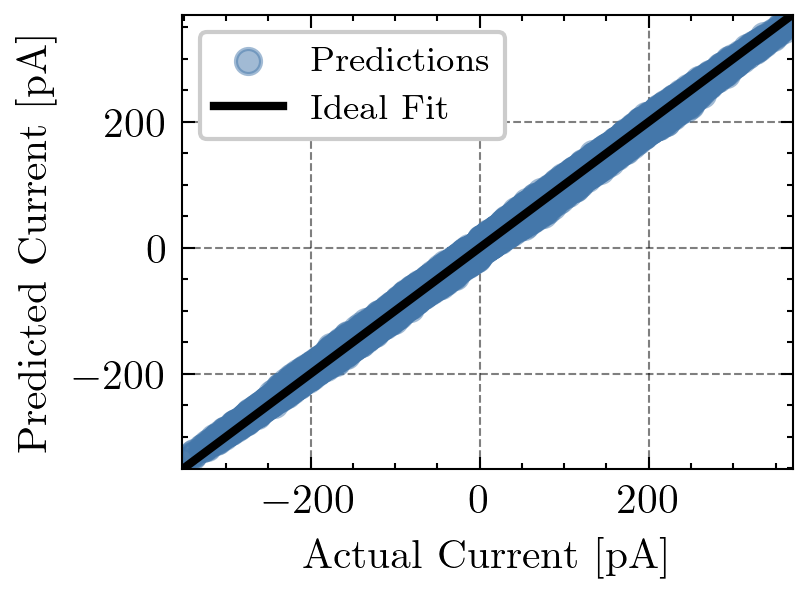

In [112]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

y_pred = data['Observable']*1e-6
y_true = df_wo_scale['Observable']*1e-6

ax.scatter(y_true, y_pred, alpha=0.5, label='Predictions')
ax.plot(np.array([y_true.min(), y_true.max()]), np.array([y_true.min(), y_true.max()]), 'black', linewidth=2, label='Ideal Fit')
ax.set_xlim(np.array([y_true.min(), y_true.max()]))
ax.set_ylim(np.array([y_true.min(), y_true.max()]))
ax.set_xlabel("Actual Current~[pA]")
ax.set_ylabel("Predicted Current~[pA]")
ax.legend(fontsize='small')

In [93]:
# fig, ax = plt.subplots(dpi=300)
# w, h    = fig.get_size_inches()
# scale   = 0.75
# fig.set_size_inches(w * scale, h * scale)

# ax.plot(np.abs(y_true),np.abs(y_pred-y_true).values, marker='o', ls='', alpha=0.5)
# ax.set_yscale('log')
# ax.set_xscale('log')

In [101]:
data

,E0,E1,E2,E3,E4,E5,E6,Observable,Error
0,-0.043745,0.008090,0.016224,0.006955,-0.042358,0.00,0.00,-1.464085e+07,0.0
1,-0.043745,0.008090,0.016224,0.006955,-0.042358,0.01,0.00,-4.157118e+06,0.0
2,-0.043745,0.008090,0.016224,0.006955,-0.042358,0.00,0.01,-4.950166e+06,0.0
3,-0.043745,0.008090,0.016224,0.006955,-0.042358,0.01,0.01,1.203563e+06,0.0
4,0.020857,0.015215,0.013871,-0.004994,-0.041126,0.00,0.00,-3.680743e+06,0.0
...,...,...,...,...,...,...,...,...,...
39995,0.010285,0.031039,0.016214,-0.015040,-0.023324,0.01,0.01,2.314934e+07,0.0
39996,0.037325,0.012234,0.036878,0.021461,0.043787,0.00,0.00,6.202338e+07,0.0
39997,0.037325,0.012234,0.036878,0.021461,0.043787,0.01,0.00,8.059887e+07,0.0
39998,0.037325,0.012234,0.036878,0.021461,0.043787,0.00,0.01,7.969042e+07,0.0


In [94]:
df_comp         = pd.DataFrame()
df_box          = fitness_data.loc[:,'AND Fitness':]
df_box.columns  = ["AND", "OR", "XOR", "NAND", "NOR", "XNOR"]
df_box          = df_box.melt(value_name='Fitness', var_name='Gate')
df_box['Type']  = 'Surrogate'
df_comp         = pd.concat([df_comp,df_box],ignore_index=True)

df_box          = fitness_wo_scale.loc[:,'AND Fitness':]
df_box.columns  = ["AND", "OR", "XOR", "NAND", "NOR", "XNOR"]
df_box          = df_box.melt(value_name='Fitness', var_name='Gate')
df_box['Type']  = 'MC Sample'
df_comp         = pd.concat([df_comp,df_box],ignore_index=True)

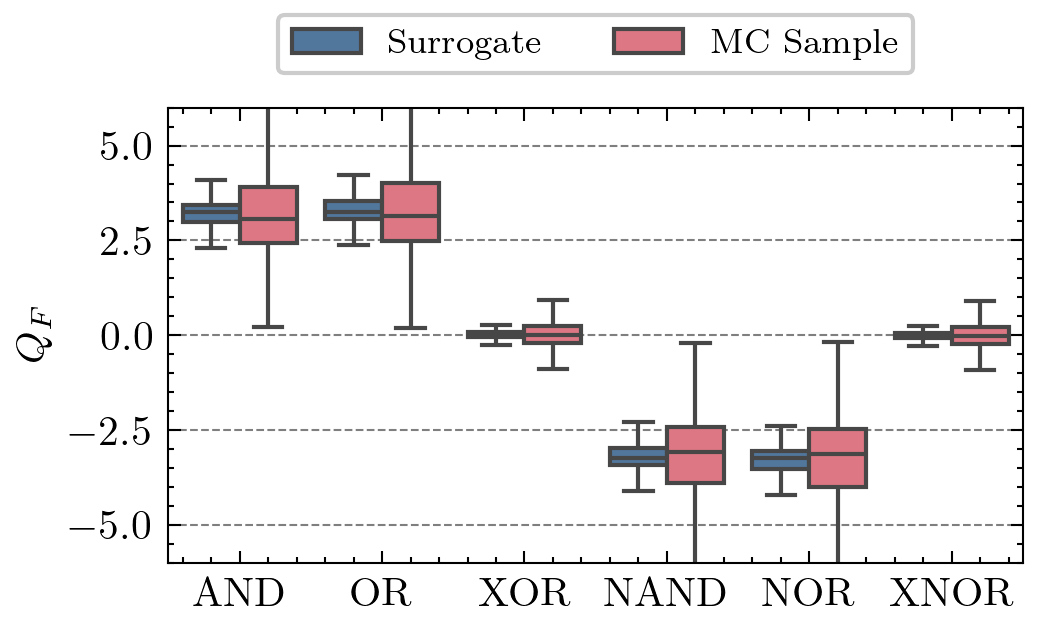

In [95]:
fig, ax = plt.subplots(dpi=300)
fig.set_figheight(fig.get_figheight()*1.0)
fig.set_figwidth(fig.get_figwidth()*1.4)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax  = sns.boxplot(df_comp, x='Gate', y='Fitness', hue='Type', fliersize=0)
# ax  = sns.violinplot(df_comp, x='Gate', y='Fitness', density_norm='width', inner=None, hue='Type', gridsize=500)
_   = ax.set_xlabel("")
_   = ax.set_ylabel("$Q_F$")
_   = ax.set_ylim(-6,6)
leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.14), ncol=2, fontsize='small')

In [96]:
N_PARTICLES = 9
N_E         = 8
V_ON        = 0.01
V_OFF       = 0.0
V_RANGE     = 0.05
INPUT_POS   = [1,3]
SCALE       = True
INPUT_COL   = [f"E{INPUT_POS[0]}",f"E{INPUT_POS[1]}"]
N_SAMPLES   = 10000
TOPO        = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
                "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                [N_PARTICLES-1,int((N_PARTICLES)/2)],
                [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
                "electrode_type" : ['constant']*N_E}

In [97]:
Q_NDR_l = []
Q_NDR_r = []
Q_NLS   = []
for i in range(7):
    for j in range(7):
        if i != j:
            voltages        = logic_gate_sample(V_RANGE, [i,j], N_SAMPLES, TOPO, V_ON, sample_technique='uniform')
            voltages        = voltages[:,:-2]
            voltages_s      = x_scaler.transform(voltages)
            current_data_s  = model.predict(voltages_s)
            current_data    = y_scaler.inverse_transform(current_data_s).flatten()
            data            = pd.DataFrame(np.hstack((voltages,current_data[:,np.newaxis],np.zeros(shape=(len(current_data),1)))),
                                        columns=([f"E{i}" for i in range(7)]+['Observable','Error']))
            arr_nonlinear   = nonlinear_parameter(data,input1_column=f'E{i}',input2_column=f'E{j}')
            Q_NDR_l.append(return_ndr(arr_nonlinear['Ml'].values))
            Q_NDR_r.append(return_ndr(arr_nonlinear['Mr'].values))
            Q_NLS.append(return_nls(arr_nonlinear))
        else:
            Q_NDR_l.append(np.nan)
            Q_NDR_r.append(np.nan)
            Q_NLS.append(np.nan)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
1250/1250 

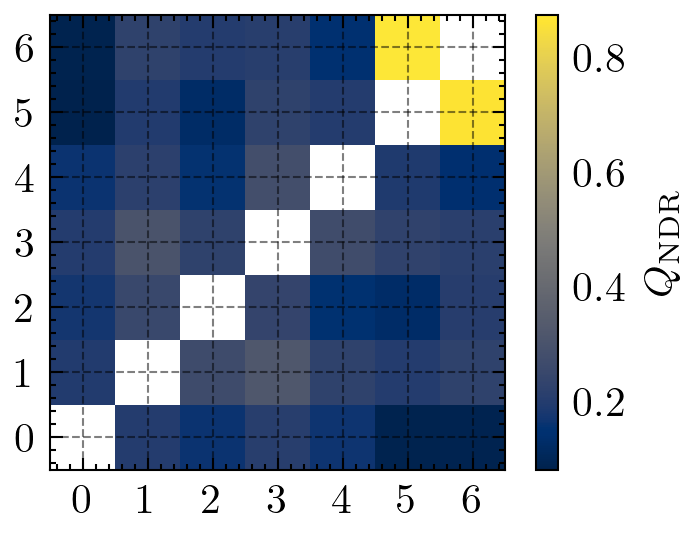

In [100]:
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

im  = ax.imshow(np.array(Q_NLS).reshape(7,7)*100, cmap='cividis', origin='lower')
_   = ax.set_xticks(np.arange(7))
_   = ax.set_yticks(np.arange(7))
cb  = fig.colorbar(im, ax=ax, label="$Q_\\textrm{NDR}$")